In [1]:
include("TrajectoryOptimization.jl")



include("bullet_collision.jl")
include("load_common.jl")

using MAT

using AstrobeeRobot

using RigidBodySim
using RigidBodyDynamics

using MeshCat
using MeshCatMechanisms
import GeometryTypes: HyperRectangle, Vec, HomogenousMesh
import ColorTypes: RGBA

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/68a213444af81a792a622d24c9ee9b29483dffff-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/68a213444af81a792a622d24c9ee9b29483dffff-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

INFO: Loading HttpServer methods...


In [2]:
include("freeflyer/load.jl")
P = MPProblem();
P.world.btenvironment_keepout

In [3]:
# vars = matread("ISSzones.mat")
vars = matread("freeflyer/iss.mat")

P.world.keepin_zones = Vector{HyperRectangle}(0)
for zone in vars["keepin_zones"]
    push!(P.world.keepin_zones,
        HyperRectangle(Vec3f0(zone["corner1"]),Vec3f0(zone["corner2"]-zone["corner1"])))
end

P.world.keepout_zones = Vector{GeometryPrimitive}(0)
push!(P.world.keepout_zones, HyperSphere(Point3f0(4.,-0.5,5.), 0.1f0))
push!(P.world.keepout_zones, HyperSphere(Point3f0(5,0.5,4.), 0.2f0))
push!(P.world.keepout_zones, HyperRectangle(Vec3f0(4.,0.5,5.),Vec3f0(0.5,0.5,0.5)))
push!(P.world.keepout_zones, HyperRectangle(Vec3f0(6.,0.,4.5),Vec3f0(0.25,0.25,0.25)))
push!(P.world.keepout_zones, HyperSphere(Point3f0(2.5,0.,4.75), 0.1f0))

P.init,P.goal = zeros(12),zeros(12)
P.init[1:3],P.goal[1:3] = [3.;-0.5;4.5], [10.;-0.5;4.5]
P.init[1:3],P.goal[1:3] = [3.;-0.5;4.3], [9.0;0.54;5.2]
P.init[4:6],P.goal[4:6] = zeros(3), zeros(3)
P.init[10:12],P.goal[10:12] = zeros(3), zeros(3);

update_aabb!(P.world)

In [4]:
outside_obstacles = []
push!(outside_obstacles, HyperRectangle(Vec3f0(P.world.keepin_zones[2].origin-[0.;0.1;0]),
        Vec3f0(P.world.keepin_zones[2].widths[1]+P.world.keepin_zones[3].widths[1]+
        P.world.keepin_zones[14].widths[1]+P.world.keepin_zones[15].widths[1],
        0.1,
        P.world.keepin_zones[2].widths[3])))
push!(outside_obstacles, HyperRectangle(Vec3f0(P.world.keepin_zones[2].origin+[0.;P.world.keepin_zones[2].widths[2]-0.1;0]),
        Vec3f0(P.world.keepin_zones[2].widths[1]+P.world.keepin_zones[3].widths[1]+
        P.world.keepin_zones[14].widths[1]+P.world.keepin_zones[15].widths[1],
        0.1,
        P.world.keepin_zones[2].widths[3])))
push!(outside_obstacles, HyperRectangle(Vec3f0(P.world.keepin_zones[2].origin+[0;0;P.world.keepin_zones[2].widths[3]]),
        Vec3f0(P.world.keepin_zones[2].widths[1]+P.world.keepin_zones[3].widths[1]+
        P.world.keepin_zones[14].widths[1]+P.world.keepin_zones[15].widths[1],
            P.world.keepin_zones[2].widths[2],
            0.1)))
push!(outside_obstacles, HyperRectangle(Vec3f0(P.world.keepin_zones[2].origin+[0;0;-0.1]),
        Vec3f0(P.world.keepin_zones[2].widths[1]+P.world.keepin_zones[3].widths[1]+
        P.world.keepin_zones[14].widths[1]+P.world.keepin_zones[15].widths[1],
            P.world.keepin_zones[2].widths[2],
            0.1)))
push!(outside_obstacles, HyperRectangle(Vec3f0(P.world.keepin_zones[2].origin+[P.world.keepin_zones[2].widths[1];0;0]),
        Vec3f0([P.world.keepin_zones[15].origin[1]-(P.world.keepin_zones[2].origin[1]+P.world.keepin_zones[2].widths[1])
                ;P.world.keepin_zones[2].widths[2];P.world.keepin_zones[3].origin[3]-P.world.keepin_zones[2].origin[3]])))
push!(outside_obstacles, HyperRectangle(Vec3f0([P.world.keepin_zones[2].origin[1]+P.world.keepin_zones[2].widths[1];
                P.world.keepin_zones[2].origin[2];
                P.world.keepin_zones[3].origin[3]+P.world.keepin_zones[3].widths[3]]),
        Vec3f0([P.world.keepin_zones[15].origin[1]-(P.world.keepin_zones[2].origin[1]+P.world.keepin_zones[2].widths[1])
                ;P.world.keepin_zones[2].widths[2];
                (P.world.keepin_zones[2].origin[3]+P.world.keepin_zones[2].widths[3])-(P.world.keepin_zones[3].origin[3]+P.world.keepin_zones[3].widths[3])])))
push!(outside_obstacles, HyperRectangle(Vec3f0(P.world.keepin_zones[2].origin+[P.world.keepin_zones[2].widths[1];0;
                P.world.keepin_zones[3].origin[3]-P.world.keepin_zones[2].origin[3]]),
        Vec3f0([P.world.keepin_zones[15].origin[1]-(P.world.keepin_zones[2].origin[1]+P.world.keepin_zones[2].widths[1]);
                P.world.keepin_zones[3].origin[2]-P.world.keepin_zones[2].origin[2];
                P.world.keepin_zones[3].widths[3]])))
push!(outside_obstacles, HyperRectangle(Vec3f0([P.world.keepin_zones[2].origin[1]+P.world.keepin_zones[2].widths[1];
                P.world.keepin_zones[3].origin[2]+P.world.keepin_zones[3].widths[2];
                P.world.keepin_zones[3].origin[3]]),
        Vec3f0([P.world.keepin_zones[15].origin[1]-(P.world.keepin_zones[2].origin[1]+P.world.keepin_zones[2].widths[1]);
                P.world.keepin_zones[3].origin[2]-P.world.keepin_zones[2].origin[2];
                P.world.keepin_zones[3].widths[3]])))
for obs in outside_obstacles
    push!(P.world.keepout_zones,obs)
end

In [5]:
# define environment for keepin_zones
P.world.btenvironment_keepin = BT.BulletStaticEnvironment(BT.sphere(P.init[1:3],P.robot.r),
    BT.collision_world(P.world.worldAABBmin, P.world.worldAABBmax))
for zone in P.world.keepin_zones
    BT.add_collision_object!(P.world.btenvironment_keepin,BT.geometry_type_to_BT(zone)) 
end

In [6]:
# define environment for keepout zones
P.world.btenvironment_keepout = BT.BulletStaticEnvironment(BT.sphere(P.init[1:3],P.robot.r),
    BT.collision_world(P.world.worldAABBmin, P.world.worldAABBmax))
for zone in P.world.keepout_zones
    BT.add_collision_object!(P.world.btenvironment_keepout, BT.geometry_type_to_BT(zone)) 
end

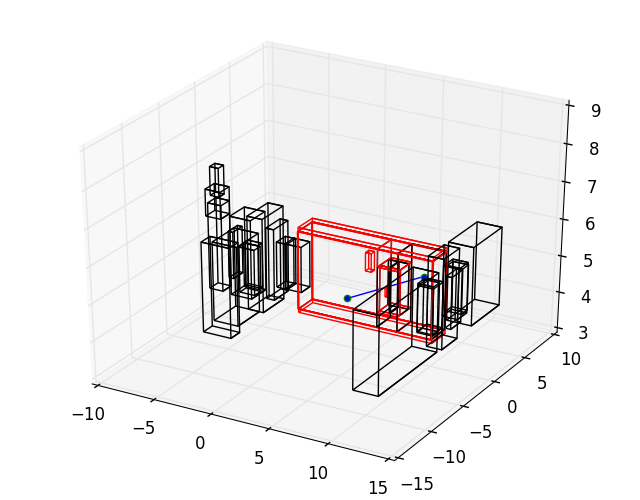

In [7]:
n,m = P.x_dim,P.u_dim
rb = P.robot
Tf,N = P.tf_max, 21
dt = Tf/(N-1)

X0 = zeros(n,N)
U0 = zeros(m,N-1)

q0,q1 = mrp2quat(P.init[7:9,1]), mrp2quat(P.goal[7:9,end])
for (k,t) in enumerate(linspace(0,1,N))
    X0[1:3,k] =  P.init[1:3,1]*(1-t) + P.goal[1:3,end]*t
    X0[7:9,k] = quat2mrp(quat_interp(q0,q1,t))
end

for zone in P.world.keepin_zones
    plot_shape(zone,"black")
end
for zone in P.world.keepout_zones
    typeof(zone) <: GeometryTypes.HyperRectangle && plot_shape(zone,"red")
end

PyPlot.scatter3D(P.init[1], P.init[2], P.init[3], color="green")
PyPlot.scatter3D(P.goal[1], P.goal[2], P.goal[3], color="green")
PyPlot.plot3D(X0[1,:], X0[2,:], X0[3,:])
#PyPlot.plot3D(Xh[last_idx][1,:],Xh[last_idx][2,:],Xh[last_idx][3,:])

#PyPlot.figure()
labels=["x","y","z"]
colors=["red","black","green"]
for k in 1:3
#    PyPlot.plot(X0[k+6,:],label=labels[k],color=colors[k])
end
#PyPlot.legend(loc="best")
#PyPlot.xlabel("Time [s]"); PyPlot.title("MRP")

In [8]:
# ********************************************
# ******  PRE-SCRIPT - STOMP CONSTANTS  ******
# ********************************************
include("stomp.jl")
using Distributions
srand(123)

# parameters
# ab = Astrobee()
weight_torques = 1e-6
weight_ref = 1e-7 # cost on distance to Q0
weight_ref = 0 # cost on distance to Q0
body_radius = P.robot.r # 0.05
# body_mass = get(P.robot.mass, :threeD, 0) # 7.0
body_mass = P.robot.mass
if body_mass == 0
    println("[stomp_freeflyer]: Robot mass not found and set to $body_mass")
end
body_inertia     = P.robot.J
body_inertia_inv = P.robot.Jinv
epsilon_obstacles = 1e-2 # redefined later depending on discretization of distances table
delta_cost_stop = 0.05
nb_iter_max = 300
h = 10 # hyperparameter, replaces lambda (see eq. 11)
p = 3  # statespace dimension
N = 100 # number of discretized points (including initial/final)
NB_MOTORS = P.robot.n_thrusters::Int
T = 5 # horizon, in [s] (NOTE: 100samples/sec looks like what they used in paper)
dt = T/N # timestep
K = 5 # number noise trajectories
# x0,xf = zeros(3), 2*ones(3) # initial/final positions
q0,qf = copy(vcat(P.init[1:3],P.init[7:9,1])), copy(vcat(P.goal[1:3],P.goal[7:9,end]))  # initial/final configurations
Q_ROT_COEFFS = 4:6
x0,xf = q0[1:3],qf[1:3]
# Initial trajectory (linear interpolation from initial to final conf., including those)
Q0 = zeros(p,N) # parameters
for dim in 1:min(3,p)
    Q0[dim,:] = collect(linspace(q0[dim],qf[dim],N))
end
if p > 3
    quat0,quatf = mrp2quat(q0[Q_ROT_COEFFS]), mrp2quat(qf[Q_ROT_COEFFS])
    for (k,t) in enumerate(linspace(0,1,N))
        Q0[Q_ROT_COEFFS, k] =  quat2mrp(quat_interp(quat0,quatf,t))
    end
end

# *****************************************
Aacc = get_finite_differencing_acceleration_matrix(N+2*2, dt)
Racc = Aacc'*Aacc

# A = zeros(N,N)
# A = A - 30.0/12.0*diagm(ones(N))
# A = A + 16.0/12.0*diagm(ones(N-1),1) + 16.0/12.0*diagm(ones(N-1),-1)
# A = A - 1/12.0*diagm(ones(N-2),2) - 1/12.0*diagm(ones(N-2),-2)
# A = A/(dt^2)
A = get_finite_differencing_acceleration_matrix(N, dt)
R = A'*A
# Rinv = inv(R)
Rinv = inv(Racc)[3:end-2,3:end-2]
Rinv = (Rinv+ Rinv'); # Make it symmetrical, it's not before (rounding errors)
M = copy(Rinv)
for col_i = 1:size(M,2)
    max_col_i = maximum(M[:, col_i])
    M[:,col_i] = M[:,col_i] / (max_col_i*N)
end


In file included from /Cxx.cpp:1:
In file included from :9:
/home/marco/scp_se3/src/distanceComputation.h:1:6: error: redefinition of 'compute_distance'
void compute_distance(const btCollisionShape* cs1, const btTransform& tr1,
     ^
/home/marco/scp_se3/src/distanceComputation.h:1:6: note: previous definition is here
void compute_distance(const btCollisionShape* cs1, const btTransform& tr1,
     ^


In [9]:
P.robot.r
P.world.btenvironment_keepout

BT.BulletStaticEnvironment((class btCollisionObject *) @0x0000000009b66060
, Cxx.CppPtr{Cxx.CxxQualType{Cxx.CppBaseType{:btCollisionObject},(false, false, false)},(false, false, false)}[(class btCollisionObject *) @0x0000000009b162a0
], (class btCollisionWorld *) @0x00000000090782a0
, Cxx.CppPtr{Cxx.CxxQualType{Cxx.CppBaseType{:btCollisionObject},(false, false, false)},(false, false, false)}[(class btCollisionObject *) @0x0000000009bb70c0
, (class btCollisionObject *) @0x00000000094b0e60
, (class btCollisionObject *) @0x0000000009baa020
, (class btCollisionObject *) @0x0000000009ba2fe0
, (class btCollisionObject *) @0x00000000099e4270
, (class btCollisionObject *) @0x00000000072de960
, (class btCollisionObject *) @0x000000000a134830
, (class btCollisionObject *) @0x0000000009ba9cb0
, (class btCollisionObject *) @0x0000000009b18240
, (class btCollisionObject *) @0x0000000008fe4cb0
, (class btCollisionObject *) @0x00000000099d9ac0
, (class btCollisionObject *) @0x00000000094c4f10
, (clas

In [10]:
# compute distances to all objects and save results in a table
if(!isdefined(:DIST2OBS_MAT))
    NX = 131 # number of points along each dimension
    X_MIN, X_MAX = x0-(xf-x0)/4, xf+(xf-x0)/4
    DX = (X_MAX[1]-X_MIN[1])
    dx = DX/(NX-1)
    println("The distances table will have a precision of $(dx/2) meters")
    grid_precision = dx/2
#     function create_table_distances()
#         last_println = 0
#         println("[create_table_distancesxid] Starting to compute the distances table...")
#         for xid = 1:NX
#             if last_println>=NX/10
#                 println("[create_table_distancesxid] Done at $(100*xid/NX)%")
#                 last_println = 0
#             else
#                 last_println = last_println + 1
#             end

#             x = X_MIN[1] + (xid-1)*DX/(NX-1)
#             for yid = 1:NX
#                 y = X_MIN[2] + (yid-1)*DX/(NX-1)
#                 for zid = 1:NX
#                     z = X_MIN[3] + (zid-1)*DX/(NX-1)
#                     pt_coords_3d = [x,y,z]
#                     min_distance = Inf
#                     for obs in P.world.btenvironment_keepout.convex_env_components
#                         pt = BT.convex_hull([SVector{3}(pt_coords_3d)]) # represent a point using convex hull
#                         distance_to_obs = BT.distance(pt,obs)[1]# zero if inside obstacle
#                         if min_distance > distance_to_obs
#                             min_distance = distance_to_obs
#                         end
#                     end
#                     DIST2OBS_MAT[xid,yid,zid] = min_distance
#                 end
#             end
#         end   
#         println("[create_table_distancesxid] Computed distance table")
#         return DIST2OBS_MAT
#     end
    # table with all signed euclidean distances to the closest obstacle for all points
    DIST2OBS_MAT = zeros(NX,NX,NX)
    DIST2OBS_MAT = create_table_distances(NX, X_MIN, DX, P.world.btenvironment_keepout);
end

The distances table will have a precision of 0.03461538461538462 meters
[create_table_distancesxid] Starting to compute the distances table...
[create_table_distancesxid] Done at 11.450381679389313%
[create_table_distancesxid] Done at 22.900763358778626%
[create_table_distancesxid] Done at 34.35114503816794%
[create_table_distancesxid] Done at 45.80152671755725%
[create_table_distancesxid] Done at 57.25190839694657%
[create_table_distancesxid] Done at 68.70229007633588%
[create_table_distancesxid] Done at 80.1526717557252%
[create_table_distancesxid] Done at 91.6030534351145%
[create_table_distancesxid] Computed distance table


131×131×131 Array{Float64,3}:
[:, :, 1] =
 0.282518  0.282518  0.282518  …  6.94713  7.01636  7.08559  7.15482
 0.282518  0.282518  0.282518     6.94713  7.01636  7.08559  7.15482
 0.282518  0.282518  0.282518     6.94713  7.01636  7.08559  7.15482
 0.282518  0.282518  0.282518     6.94713  7.01636  7.08559  7.15482
 0.282518  0.282518  0.282518     6.94713  7.01636  7.08559  7.15482
 0.282518  0.282518  0.282518  …  6.94713  7.01636  7.08559  7.15482
 0.282518  0.282518  0.282518     6.94713  7.01636  7.08559  7.15482
 0.282518  0.282518  0.282518     6.94713  7.01636  7.08559  7.15482
 0.282518  0.282518  0.282518     6.94713  7.01636  7.08559  7.15482
 0.282518  0.282518  0.282518     6.94713  7.01636  7.08559  7.15482
 0.282518  0.282518  0.282518  …  6.94713  7.01636  7.08559  7.15482
 0.282518  0.282518  0.282518     6.94713  7.01636  7.08559  7.15482
 0.282518  0.282518  0.282518     6.94713  7.01636  7.08559  7.15482
 ⋮                             ⋱                             

In [11]:
# function get_dist2obs{T}(pt_3d::Vector{T})
#     idx_in_tab = zeros(3);
#     for dim in 1:3
#         idx_in_tab[dim] = (pt_3d[dim]-X_MIN[dim]) / DX
#         if idx_in_tab[dim] < 0
# #             println("not enough")
#             idx_in_tab[dim] = 1
#         elseif idx_in_tab[dim] > 1
# #             println("too much")
#             idx_in_tab[dim] = NX
#         else
#             idx_in_tab[dim] = 1+idx_in_tab[dim]*(NX-1)
#         end
#     end
#     idx_in_tab = round.(Int,idx_in_tab)
#     x = X_MIN[1] + (idx_in_tab[1]-1)*DX/(NX-1)
#     y = X_MIN[2] + (idx_in_tab[2]-1)*DX/(NX-1)
#     z = X_MIN[3] + (idx_in_tab[3]-1)*DX/(NX-1)
#     #println("index in tab: $idx_in_tab located at [$x $y $z]")
#     return DIST2OBS_MAT[idx_in_tab[1],idx_in_tab[2],idx_in_tab[3]]
# end

In [12]:
# # Computes the velocity magnitudes for each 3d point in 'points'
# function compute_velocities_mag{T}(points::Matrix{T})
# #     diff_mat_vel = zeros(N,N)
# #     diff_mat_vel = diagm(ones(N)) - diagm(ones(N-1),-1); diff_mat_vel[1,1] = 0;
# #     diff_mat_vel = diff_mat_vel / dt
#     diff_mat_vel = zeros(N+1,N+1)
#     diff_mat_vel = diagm(ones(N+1)) - diagm(ones(N+1-1),-1);
#     diff_mat_vel = diff_mat_vel / dt
    
#     velocities = similar(points);
#     pts_extended = zeros(p,N+1)
#     pts_extended = hcat(points[:,1],points[:,:])
#     for dim=1:p
# #         velocities[dim,:] = (diff_mat_vel * points[dim,:])'
#         velocities[dim,:] = (diff_mat_vel * pts_extended[dim,:])'[2:end]
#     end

#     vel_mag = zeros(N)
#     for i=1:N
#         vel_mag[i] = sqrt(sum(velocities[:,i].^2))
#     end
    
#     return vel_mag
# end
# # Compute all velocities
# velocities_mag = zeros(N)
# velocities_mag = compute_velocities_mag(Q0)

# # Computes the torques required for each motor (cost)
# function compute_torques{T}(Q_::Matrix{T}) # configurations
#     # TODO CHANGE THAT, REPLACE WITH INVERSE DYNAMICS ALGORITHMS, see eq (15)
        
#     # put inverse dynamics here
#     # put inverse dynamics here
#     # put inverse dynamics here
#     Q_accels = zeros(p,N)
#     for dim=1:p
#         # Assumes initial points are the same as 1st element of Q, and similarly for the end
# #         Q_accels[dim,:] = A * Q[dim, :]
#         Q_accels[dim,:] = (Aacc * [Q_[dim,1];Q_[dim,1];Q_[dim,:];Q_[dim,end];Q_[dim,end]])[3:end-2]
#     end
#     torques = zeros(NB_MOTORS,N) # torques of each motor for each timestep
#     for nidx=1:N
#         for motor_i = 1:NB_MOTORS
#             if motor_i <= 3
# #                 torques[motor_i,:] = body_mass*sqrt(sum(Q_accels[:,nidx]).^2)
#                 torques[motor_i,nidx] = body_mass*sqrt((Q_accels[motor_i,nidx]).^2)
#             elseif motor_i > 3 && motor_i <= p && p > 3
# #                 torques[motor_i,nidx] = body_inertia[*sqrt(sum(Q_accels[motor_i,nidx]).^2)
#                 torques[motor_i,nidx] = body_inertia[motor_i-3,motor_i-3]*sqrt((Q_accels[motor_i,nidx]).^2)
#             end
#         end
#     end
#     # put inverse dynamics here
#     # put inverse dynamics here
#     # put inverse dynamics here
        
#     return torques
# end
# # Compute all velocities
# torques = zeros(NB_MOTORS,N)
# torques = compute_torques(Q0, NB_MOTORS)


In [13]:
# function get_total_jointsAccels_cost{T}(Q_::Matrix{T})
#     Jacc = 0
# #     Jacc1 = 0
#     for dim = 1:p
#         # Assumes initial points are the same as 1st element of Q, and similarly for the end
# #         Jacc1 = Jacc1 + Q_[dim,:]' * R * Q_[dim,:]
#         Qextended = [Q_[dim,1];Q_[dim,1];Q_[dim,:];Q_[dim,end];Q_[dim,end]]
#         Jacc = Jacc + Q_[dim,:]' * ((Racc * Qextended)[3:end-2])
#     end
    
#     return Jacc
# end
# # get_total_jointsAccels_cost(Q0)
# function get_total_obstacles_cost{T}(Q_::Matrix{T})
# #     N = T
    
#     velocities_mag_ = zeros(N)
#     velocities_mag_ = compute_velocities_mag(Q_)
    
#     Jobs_ = 0
#     for nidx = 1:N
#         # put forward kinematics here
#         # put forward kinematics here
#         qconf_ = Q_[1:3, nidx] 
#         # put forward kinematics here
#         # put forward kinematics here

#         dist_ = get_dist2obs(qconf_)
#         Jobs_ = Jobs_ + max(epsilon_obstacles+grid_precision+body_radius-dist_, 0)*velocities_mag_[nidx]
#     end
    
#     return Jobs_
# end
# function is_trajectory_collision_less{T}(Q_::Matrix{T})
#     is_not_collision = true
#     Jobs_ = 0
#     for nidx = 1:N
#         # put forward kinematics here
#         # put forward kinematics here
#         qconf_ = Q_[1:3, nidx] 
#         # put forward kinematics here
#         # put forward kinematics here

#         dist_ = get_dist2obs(qconf_)
#         if (epsilon_obstacles+grid_precision+body_radius-dist_ > 0)
#             is_not_collision = false
#             return is_not_collision
#         end
#     end
    
#     return is_not_collision
# end
# function get_total_torques_cost{T}(Q_::Matrix{T})
# #     N = T
    
#     velocities_mag_ = zeros(N)
#     velocities_mag_ = compute_velocities_mag(Q_)
#     torques_ = zeros(NB_MOTORS,N)
#     torques_ = compute_torques(Q_, NB_MOTORS)
    
#     Jtorques_ = 0
#     for nidx = 1:N
#         Jtorques_ = Jtorques_ + weight_torques*sum(abs.(torques_[:,nidx]))
#     end
    
#     return Jtorques_
# end
# function get_total_refDeviation_cost{T}(Q_::Matrix{T}, Q0_::Matrix{T})
# #     N = T
    
#     Jref_ = 0
#     for nidx = 1:N
#         qconf_ = Q_[:, nidx] 
#         Jref_ = Jref_ + weight_ref*sqrt(sum((qconf_-Q0_[:,nidx]).^2))
#     end
    
#     return Jref_
# end

# # Cost function. Returns the cost for a given configuration qconf
# # and the velocity of the corresponding qconf identified by id_vel (precomputed in velocities_mag)
# function cost{T}(qconf_::Vector{T}, id_vel_::Any, nidx_::Any)
#     dist_ = get_dist2obs(qconf_)
    
#     # obstacle cost (eq 13)
# #     println(dist)
#     cost_obs_ = max(epsilon_obstacles+grid_precision+body_radius-dist_, 0)*velocities_mag[id_vel_]
    
#     # joint torques costs
#     cost_torques_ = weight_torques*sum(abs.(torques[:,nidx_]))
# #     cost_torques_ = 0
    
#     # distance to reference cost
#     cost_qconf_ref_ = weight_ref*sqrt(sum((qconf_-Q0[:,nidx_]).^2))
# #     cost_qconf_ref_ = 0
    
#     Jm_ = 1e-5 + cost_obs_ + cost_torques_ + cost_qconf_ref_
#     return Jm_
# end

# # Cost function. Returns the cost for a given configuration qconf
# # and the velocity of the corresponding qconf identified by id_vel (precomputed in velocities_mag)
# function cost_println{T}(qconf_::Vector{T}, id_vel_::Any, nidx_::Any)
# #     dist = dist2obs(qconf)
#     dist_ = get_dist2obs(qconf_)
    
#     # obstacle cost (eq 13)
#     cost_obs_ = max(epsilon_obstacles+grid_precision+body_radius-dist_, 0)*velocities_mag[id_vel_]
    
#     # joint torques costs
#     cost_torques_ = weight_torques*sum(abs.(torques[:,nidx_]))
# #     cost_torques = 0
    
#     # distance to reference cost
#     cost_qconf_ref_ = weight_ref*sqrt(sum((qconf_-Q0[:,nidx_]).^2))
# #     cost_qconf_ref = 0
    
#     Jm_ = 1e-3 + cost_obs_ + cost_torques_ + cost_qconf_ref_
#     println("Contribution of costs: ")
#     println("cost_obs:       $(cost_obs/Jm)%")
#     println("cost_torques:   $(cost_torques/Jm)%")
#     println("cost_qconf_ref: $(cost_qconf_ref/Jm)%")
#     return Jm_
# end

In [14]:
# include("stomp.jl")
# ********************************************
# ****** MAIN SCRIPT - IMPLEMENTS STOMP ******
# ********************************************
# note: for all variables, subscripts are in this order: dimension(p) x samples(N) x trajectoryId(K)
Dist = MvNormal(zeros(N),Rinv) # create normal distribution
Q = copy(Q0) # configuration
Qperturbed = zeros(p,N,K)
Qbest = zeros(p,N,K)
Qall  = zeros(p,N,2*K)
id_Qsave = 1
for kidx = 1:K
    Qbest[:,:,kidx] = Q0
end
velocities_mag = compute_velocities_mag(Q)
torques = compute_torques(Q, NB_MOTORS, body_mass, body_inertia)

Jtot = 0+delta_cost_stop+1e-5; 
Jtot = get_total_jointsAccels_cost(Q)
for nidx = 1:N
    Jtot = Jtot + cost(Q[:,nidx],Q0,nidx, nidx, epsilon_obstacles+grid_precision, body_radius,
                       velocities_mag, torques, weight_torques, weight_ref, 
                       DIST2OBS_MAT, NX, X_MIN, DX)
end
println("Initial cost: $(Jtot/N)")
Jprev = 0
iter_i = 1;
Qk = zeros(p,N,nb_iter_max)
Jk = get_total_obstacles_cost(Q, epsilon_obstacles+grid_precision, body_radius, DIST2OBS_MAT, NX, X_MIN, DX) + 
                get_total_torques_cost(Q, NB_MOTORS, weight_torques, body_mass, body_inertia) + 
                get_total_refDeviation_cost(Q, Q0, weight_ref)
Jcost = []
Qk[:,:,1] = copy(Q0)

println("Starting Stomp main loop")
tic()
# while (abs(Jprev-Jtot) >= delta_cost_stop) && (iter_i <= nb_iter_max)
last_println = 0
while iter_i <= nb_iter_max
    if last_println>=nb_iter_max/10
#         println("Starting iter# $iter_i / $nb_iter_max")
        last_println = 0
    else
        last_println = last_println + 1
    end
        
        
    Qk[:,:,iter_i] = copy(Q)
    Jk = vcat(Jk, Jcost)
    
    Jprev = copy(Jtot)
    iter_i = iter_i+1
    
    # 1) Create K noisy trajectories
    Qperturbed = zeros(p,N,K) # configuration trajectory (in time, length N) for each dimension
    eps = zeros(p,N,K)
    for kidx in 1:K # for each trajectory
        eps[:,:,kidx] = rand(Dist,p)'
        for dim in 1:p 
#             Qperturbed[dim,:,kidx]= Q[dim,:] + ((nb_iter_max-iter_i)/nb_iter_max) * eps[dim,:,kidx]
            Qperturbed[dim,:,kidx]= Q[dim,:] + eps[dim,:,kidx]
        end
    end

    # 2) Compute costs and probability metrics
    # a)
    S = zeros(N,2*K) # includes the best ones
    Prob = zeros(N,2*K)
    Qall = cat(3,Qperturbed,Qbest)
    for kidx in 1:2*K # for each trajectory
#         velocities_mag = compute_velocities_mag(Qperturbed[:,:,kidx])
#         torques = compute_torques(Qperturbed[:,:,kidx], NB_MOTORS, body_mass, body_inertia)
        velocities_mag = compute_velocities_mag(Qall[:,:,kidx])
        torques = compute_torques(Qall[:,:,kidx], NB_MOTORS, body_mass, body_inertia)
        for nidx in 1:N # get cost for each sample
#             S[nidx,kidx] = cost(Qperturbed[:,nidx,kidx], nidx, nidx)
            S[nidx,kidx] = cost(Qall[:,nidx,kidx],Q0,nidx, nidx, epsilon_obstacles+grid_precision, body_radius,
                                velocities_mag, torques, weight_torques, weight_ref, 
                                DIST2OBS_MAT, NX, X_MIN, DX)
        end
        
    end
    
    # b)
    for nidx in 1:N
        # see eq (11)
        max_S_trajs = maximum(S[nidx,:])
        min_S_trajs = minimum(S[nidx,:])
        delta_minmax_S = max_S_trajs-min_S_trajs
        
        sum_exp_S = 0
        for kidx in 1:2*K 
            sum_exp_S = sum_exp_S + exp(-h*(S[nidx,kidx]-min_S_trajs)/delta_minmax_S)
        end
        for kidx in 1:2*K 
            Prob[nidx,kidx] = exp(-h*(S[nidx,kidx]-min_S_trajs)/delta_minmax_S) / sum_exp_S
        end
    end

    # 3-4-5) perturb parameter vector
    dQ_tilde = zeros(p,N)
    for nidx in 1:N
        for kidx in 1:K 
            dQ_tilde[:,nidx] = dQ_tilde[:,nidx] + Prob[nidx,kidx] * eps[:,nidx,kidx] # 3)
        end
        for kidx in 1:K
            dQ_tilde[:,nidx] = dQ_tilde[:,nidx] + Prob[nidx,kidx] * (Qbest[:,nidx,kidx]-Q[:,nidx]) # 3)
        end
    end
    dQ = (M * dQ_tilde')' # 4)
    Q = Q + dQ # 5)
    velocities_mag = compute_velocities_mag(Q)
    torques = compute_torques(Q, NB_MOTORS, body_mass, body_inertia)

    # 6) compute total cost
    if last_println==0
        Jacc = get_total_jointsAccels_cost(Q)
        Jcost = get_total_obstacles_cost(Q, epsilon_obstacles+grid_precision, body_radius, DIST2OBS_MAT, NX, X_MIN, DX) + 
                get_total_torques_cost(Q, NB_MOTORS, weight_torques, body_mass, body_inertia) + 
                get_total_refDeviation_cost(Q, Q0, weight_ref)
        Jtot = Jacc + Jcost
        println("Current cost at step $iter_i : $(Jtot/N)")
        println("Jacc: $Jacc, Jcost: $Jcost")
#         println("$(dQ_tilde[1,20:40])")
    end
    
    # get best samples
    costs_all = zeros(2*K)
    for traj_i = 1:2*K
        costs_all[traj_i] = get_total_obstacles_cost(Qall[:,:,traj_i], epsilon_obstacles+grid_precision, body_radius, DIST2OBS_MAT, NX, X_MIN, DX) + 
                            get_total_torques_cost(Qall[:,:,traj_i], NB_MOTORS, weight_torques, body_mass, body_inertia) + 
                            get_total_refDeviation_cost(Qall[:,:,traj_i], Q0, weight_ref)
                             #+get_total_jointsAccels_cost(Qall[:,:,traj_i]) + 
    end
    Qbest = Qall[:,:,sortperm(costs_all)[1:K]]
    
#     if (is_trajectory_collision_less(Qbest[:,:,1], epsilon_obstacles+grid_precision, body_radius, DIST2OBS_MAT, NX, X_MIN, DX))
    if (is_trajectory_collision_less(Q, epsilon_obstacles+grid_precision, body_radius, DIST2OBS_MAT, NX, X_MIN, DX))
        println("Trajectory computed at iter. $iter_i is collision-less, exiting")
        break
    end
end
elapsed_opt_time = toc()
println(elapsed_opt_time)
println("Final cost: $(Jtot/N)")

# ********************************************
# ****** END MAIN SCRIPT  -    STOMP    ******
# ********************************************

LoadError: [91mUndefVarError: state not defined[39m

In [15]:
final_obs_cost = get_total_obstacles_cost(Q, epsilon_obstacles+grid_precision, body_radius, DIST2OBS_MAT, NX, X_MIN, DX)
final_torques_cost = get_total_torques_cost(Q, NB_MOTORS, weight_torques, body_mass, body_inertia)
final_ref_cost = get_total_refDeviation_cost(Q, Q0, weight_ref)
println("obstacles cost: $final_obs_cost")
println("torques   cost: $final_torques_cost")
println("reference cost: $final_ref_cost")

Jacc = get_total_jointsAccels_cost(Q)
Jcost = get_total_obstacles_cost(Q, epsilon_obstacles+grid_precision, body_radius, DIST2OBS_MAT, NX, X_MIN, DX) + 
        get_total_torques_cost(Q, NB_MOTORS, weight_torques, body_mass, body_inertia) + 
        get_total_refDeviation_cost(Q, Q0, weight_ref)
Jtot = Jacc + Jcost
println("Final cost: $Jtot")
println("Jacc: $Jacc, Jcost: $Jcost")

obstacles cost: 3.3887856134536483
torques   cost: 0.0005614141414150853
reference cost: 0.0
Final cost: 4.633960870828057e6
Jacc: 4.633957481481029e6, Jcost: 3.3893470275950635


In [16]:
# plot results
using PyPlot


PyPlot.figure()
# for traj_i in 1:nb_iter_max
    PyPlot.plot(Jk, label="Cost")
# end
PyPlot.legend(loc="best")
PyPlot.xlabel("iteration n# [-]"); PyPlot.title("Evolution of Cost")
size(Jk)

LoadError: [91mUndefVarError: Jk not defined[39m

In [17]:
costs_all = zeros(2*K)
for traj_i = 1:2*K
    costs_all[traj_i] = #get_total_jointsAccels_cost(Qall[:,:,traj_i]) + 
                        get_total_obstacles_cost(Qall[:,:,traj_i], epsilon_obstacles+grid_precision, body_radius, DIST2OBS_MAT, NX, X_MIN, DX) + 
                        get_total_torques_cost(Qall[:,:,traj_i], NB_MOTORS, weight_torques, body_mass, body_inertia) + 
                        get_total_refDeviation_cost(Qall[:,:,traj_i], Q0, weight_ref)
end
# Q_bests = Qall[:,:,sortperm(costs_all)[1:K]]
for traj_i = 1:2*K
    println(            #get_total_jointsAccels_cost(Qall[:,:,traj_i]) + 
                        get_total_obstacles_cost(Qall[:,:,traj_i], epsilon_obstacles+grid_precision, body_radius, DIST2OBS_MAT, NX, X_MIN, DX) + 
                        get_total_torques_cost(Qall[:,:,traj_i], NB_MOTORS, weight_torques, body_mass, body_inertia) + 
                        get_total_refDeviation_cost(Qall[:,:,traj_i], Q0, weight_ref)  )
end
for traj_i = 1:2*K
    println(            #get_total_jointsAccels_cost(Q_bests[:,:,traj_i]) + 
                        get_total_obstacles_cost(Qbest[:,:,traj_i], epsilon_obstacles+grid_precision, body_radius, DIST2OBS_MAT, NX, X_MIN, DX) + 
                        get_total_torques_cost(Qbest[:,:,traj_i], NB_MOTORS, weight_torques, body_mass, body_inertia) + 
                        get_total_refDeviation_cost(Qbest[:,:,traj_i], Q0, weight_ref)  )
end


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.3893470275950635
3.3893470275950635
3.3893470275950635
3.3893470275950635
3.3893470275950635


LoadError: [91mBoundsError: attempt to access 3×100×5 Array{Float64,3} at index [Base.Slice(Base.OneTo(3)), Base.Slice(Base.OneTo(100)), 6][39m

In [23]:
# Plot final results
vis = Visualizer()
delete!(vis)

vis[:obstacles]
for (idx,obs) in enumerate(P.world.keepout_zones)
    setobject!(vis[:obstacles][Symbol(string("obs",idx))], 
        Object(obs,MeshBasicMaterial(color=RGBA(1.0,0.,0.,0.05))))
end

vis[:goal]
for (idx,obs) in enumerate(P.world.keepout_zones)
    setobject!(vis[:goal][:goal], 
        Object(HyperSphere(Point3f0(P.goal[1:3]), 0.05f0)
            ,MeshBasicMaterial(color=RGBA(0,1.0,0.,0.6))))
end

vis[:workspace]
for (idx,ws) in enumerate(P.world.keepin_zones)
    setobject!(vis[:workspace][Symbol(string("ws",idx))],
        Object(ws,MeshBasicMaterial(color=RGBA(0.95,0.93,0.26,0.3))))
end

for idx in 1:N
    verts = Vector{Point3f0}(0)
    colors = Vector{RGB{Float32}}(0)
    
    push!(verts, Point3f0(Q[:,idx]))
    push!(colors, RGB(0.,0.,1.))
        
    vis[:samples]
    setobject!(vis[:samples][Symbol(string("pos"),idx)], PointCloud(verts,colors))
end

ab = Astrobee()
mvis = MechanismVisualizer(
    ab.mechanism,
    URDFVisuals(AstrobeeRobot.urdfpath(), package_path=[dirname(dirname(AstrobeeRobot.urdfpath()))]),
    vis);

Qs = Vector{Vector{Float64}}(0)
for nidx in 1:N
    mrp2quat(P.init[7:9,1]), mrp2quat(P.goal[7:9,end])
    if p > 3
        q = [mrp2quat(Q[4:6,nidx]); Q[1:3,nidx]]
    else
        q = [[1.0,0,0,0]; Q[1:3,nidx]]
    end
    push!(Qs,q)
end


# for pt_id in 1:N
# #     push!(verts, HyperSphere(Point3f0(Q[:,pt_id]), convert(Float32, body_radius)))
# #     push!(colors, RGB(0.,1.,0.))
#     setobject!(vis[:samples][Symbol(string("position",pt_id))], 
#         Object(HyperSphere(Point3f0(Q[1:3,pt_id]), convert(Float32, body_radius)),
#             MeshBasicMaterial(color=RGB(0.,1.,0.))))
# end

in_cell = false
in_cell ? IJuliaCell(vis) : open(vis)

sleep(1)
setanimation!(mvis,1:length(Qs),Qs)


# MeshCat.convert_frames_to_video("/home/acauligi/Downloads/meshcat_1535846301245.tar");

instantiated a floating joint
Listening on 0.0.0.0:8701...


Info: Serving MeshCat visualizer at http://127.0.0.1:8701


Created new window in existing browser session.


Error handling websocket connection:
WebSockets.WebSocketClosedError("ws|server respond to OPCODE_CLOSE 1001:Going Away")

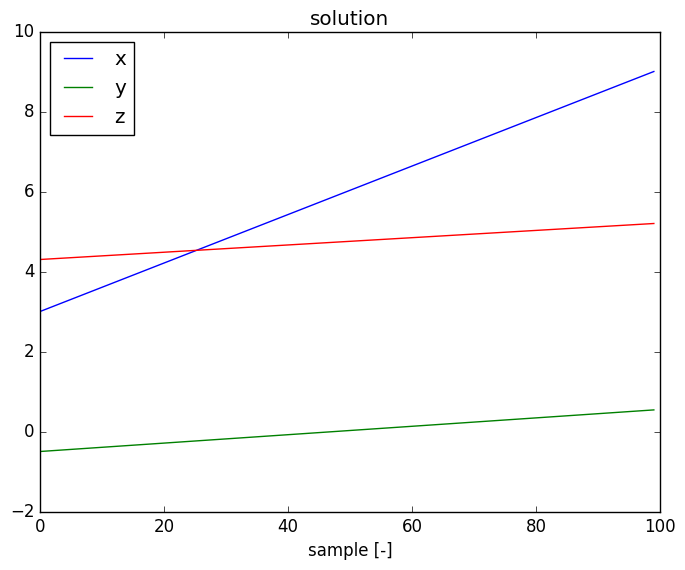

PyObject <matplotlib.text.Text object at 0x7fd55dbd77d0>

In [19]:
# plot results
using PyPlot

# Q = Qbest[:,:,1]

PyPlot.figure()
labels=["x","y","z"]
for dim in 1:min(3,p)
    PyPlot.plot(Q[dim,:],label=labels[dim])
end
PyPlot.legend(loc="best")
PyPlot.xlabel("sample [-]"); PyPlot.title("solution")

In [20]:
# plot results
# using PyPlot

# PyPlot.figure()
# for sample_k in 1:nb_iter_max
#     PyPlot.plot(Qk[2,:,sample_k])
# end
# # PyPlot.legend(loc="best")
# PyPlot.xlabel("sample [-]"); PyPlot.title("solution")



using PyCall
@pyimport matplotlib.animation as anim
using PyPlot
using Plots


using PyPlot
# x = linspace(0, 2*pi, 100) |> collect 
# dt, nsteps = 0.03, 30
fig = figure()
for iter_k = 1:nb_iter_max
    PyPlot.plot(Qk[2,:,iter_k])
    sleep(0.005)
    IJulia.clear_output(true)
    display(fig)
    clf()
end

LoadError: [91mUndefVarError: Qk not defined[39m

In [21]:
P.world.btenvironment_keepout.convex_env_components

# for zone in P.world.keepin_zones
#     plot_shape(zone,"black")
# end
vis = Visualizer()

vis[:obstacles]
for (idx,obs) in enumerate( P.world.keepout_zones)
    setobject!(vis[:obstacles][Symbol(string("obs",idx))], 
        Object(obs,MeshBasicMaterial(color=RGBA(1.0,0.,0.,1.))))
end

# plot trajectory using GeometryTypes
#verts = Vector{Point3f0}(0)
verts = Vector{HyperSphere}(0)
colors = Vector{RGB{Float32}}(0)
i = 1
Q[1:3,i] = Q[1:3,i]
# Q[1,i] = Q[1,i]+0.1
ys = Q[2,i]-0.8:0.1:Q[2,i]+2.0
# ys = 0.0-0.0:0.1:0.0+0.2
for pt_id in 1:size(ys,1)
    y = ys[pt_id]
    point = vcat(Q[1,i], y, Q[3,i])
    my_dist = get_dist2obs(point, DIST2OBS_MAT, NX, X_MIN, DX)
    println("distance from $point to closest obs: $(my_dist)")
#     println("cost due to collision with an   obs: $(max(epsilon_obstacles+body_radius-my_dist, 0))")
    
    push!(verts, HyperSphere(Point3f0(point), convert(Float32, body_radius)))
    push!(colors, RGB(0.,1.,0.))
    setobject!(vis[:samples][Symbol(string("position",pt_id))], 
        Object(verts[pt_id],MeshBasicMaterial(color=colors[pt_id])))
end
for i in 1:1
# i = idx_posx
    #k in find(not_in_collision) && continue
    #push!(verts, Point3f0(Q0[1:3,i]))
    my_dist = get_dist2obs(Q[:,i], DIST2OBS_MAT, NX, X_MIN, DX)
    println("distance from center to closest obs: $(my_dist)")
    println("epsilon_obstacles: $epsilon_obstacles")
    println("body_radius: $body_radius")
    println("cost due to collision with an   obs: $(max(epsilon_obstacles+body_radius-my_dist, 0))")

    push!(verts, HyperSphere(Point3f0(Q[1:3,i]), convert(Float32, body_radius)))
    push!(colors, RGB(0.,0.,1.))
    
    #setobject!(vis[:samples][:position], verts[i])
    setobject!(vis[:samples][Symbol(string("position",i))], 
        Object(verts[i],MeshBasicMaterial(color=colors[i])))
end

# println("min dist: $(DIST2OBS_MAT[:,1,1])")

in_cell = true
in_cell ? IJuliaCell(vis) : open(vis)

distance from [3.0, -1.3, 4.3] to closest obs: 0.2849329710006714
distance from [3.0, -1.2, 4.3] to closest obs: 0.2849329710006714
distance from [3.0, -1.1, 4.3] to closest obs: 0.2849329710006714
distance from [3.0, -1.0, 4.3] to closest obs: 0.2849329710006714
distance from [3.0, -0.9, 4.3] to closest obs: 0.2849329710006714
distance from [3.0, -0.8, 4.3] to closest obs: 0.2849329710006714
distance from [3.0, -0.7, 4.3] to closest obs: 0.3541637063026428
distance from [3.0, -0.6, 4.3] to closest obs: 0.42339444160461426
distance from [3.0, -0.5, 4.3] to closest obs: 0.49021053314208984
distance from [3.0, -0.4, 4.3] to closest obs: 0.49021074175834656
distance from [3.0, -0.3, 4.3] to closest obs: 0.49021029472351074
distance from [3.0, -0.2, 4.3] to closest obs: 0.49021053314208984
distance from [3.0, -0.1, 4.3] to closest obs: 0.49021053314208984
distance from [3.0, 0.0, 4.3] to closest obs: 0.49021053314208984
distance from [3.0, 0.1, 4.3] to closest obs: 0.49021053314208984
dist

WebIO.Scope("scope-5aeccbcf-ec5f-402a-8c32-9766e9c84114", WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :iframe), Any[], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict{String,Any}(Pair{String,Any}("height", "100%"),Pair{String,Any}("scrolling", "no"),Pair{String,Any}("src", "javascript:void(0)"),Pair{String,Any}("frameborder", 0))),Pair{Symbol,Any}(:id, "ifr"),Pair{Symbol,Any}(:style, Dict("width"=>"100%","flexGrow"=>"1"))), 0)], Dict{Symbol,Any}(Pair{Symbol,Any}(:style, Dict("flexDirection"=>"column","height"=>"100%","minHeight"=>"400px","display"=>"flex","width"=>"100%","overflow"=>"hidden"))), 1), Dict{String,Tuple{Observables.Observable,Union{Bool, Void}}}(), Set{String}(), nothing, Any[], Dict{Any,Any}(Pair{Any,Any}("_promises", Dict{Any,Any}(Pair{Any,Any}("importsLoaded", Any[WebIO.JSString("function () {\n    var frame = this.dom.querySelector(\"#ifr\");\n    var doc = frame.contentDocument\n    var win = frame.contentWindow\n\n    // Determine if we're running on a Jupyter hosting service\n    // that requires a base URL when retrieving assets\n    var curMatch =\n        window.location.href\n        .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n    curMatch = curMatch ||\n        window.location.href\n        .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n    if (curMatch) {\n        var base = doc.createElement(\"base\");\n        base.setAttribute(\"href\", curMatch[1] + '/');\n        doc.head.appendChild(base);\n    }\n\n    var webio = doc.createElement(\"script\")\n    webio.src = \"pkg/WebIO/webio/dist/bundle.js\"\n    var parent = window\n\n    function resizeIframe() {\n        doc.body.style.padding = '0'\n        doc.body.style.margin = '0'\n        doc.documentElement.height = '100%'\n        doc.body.height = '100%'\n    }\n\n    webio.onload = function () {\n        win.WebIO.sendCallback = parent.WebIO.sendCallback; // Share stuff\n        win.WebIO.scopes = parent.WebIO.scopes\n        win.WebIO.obsscopes = parent.WebIO.obsscopes\n        win.WebIO._connected = true\n        doc.body.innerHTML = \"<html><body>\" + \"<div class='display:none'></div><unsafe-script style='display:none'>\\nWebIO.mount(this.previousSibling,{&quot;props&quot;:{},&quot;nodeType&quot;:&quot;Scope&quot;,&quot;type&quot;:&quot;node&quot;,&quot;instanceArgs&quot;:{&quot;imports&quot;:{&quot;data&quot;:[{&quot;name&quot;:null,&quot;type&quot;:&quot;js&quot;,&quot;url&quot;:&quot;/assetserver/0250395fa8313ce7365c1a98c41825449a972145-main.min.js&quot;}],&quot;type&quot;:&quot;async_block&quot;},&quot;id&quot;:&quot;scope-468e5f98-a265-4c22-84f2-d6584d8a0f07&quot;,&quot;handlers&quot;:{&quot;meshcat-command&quot;:[(function (val){return this.viewer.handle_command_message({&quot;data&quot;:val})})],&quot;_promises&quot;:{&quot;importsLoaded&quot;:[(function (mc){var element=this.dom.children[0]; this.viewer=new mc.Viewer(element); WebIO.setval({&quot;name&quot;:&quot;meshcat-request&quot;,&quot;scope&quot;:&quot;scope-468e5f98-a265-4c22-84f2-d6584d8a0f07&quot;,&quot;id&quot;:&quot;ob_05&quot;,&quot;type&quot;:&quot;observable&quot;},String(Date.now())); return window.document.body.style.margin=&quot;0&quot;})]}},&quot;systemjs_options&quot;:null,&quot;observables&quot;:{&quot;meshcat-command&quot;:{&quot;sync&quot;:false,&quot;id&quot;:&quot;ob_04&quot;,&quot;value&quot;:[131,166,111,98,106,101,99,116,132,170,103,101,111,109,101,116,114,105,101,115,145,133,174,104,101,105,103,104,116,83,101,103,109,101,110,116,115,20,164,117,117,105,100,218,0,36,48,100,57,100,51,51,54,101,45,98,54,99,99,45,49,49,101,56,45,48,100,50,54,45,100,53,100,48,97,102,52,55,54,50,100,56,166,114,97,100,105,117,115,202,62,135,61,16,164,116,121,112,101,174,83,112,104,101,114,101,71,101,111,109,101,116,114,121,173,119,105,100,116,104,83,101,103,109,101,110,116,115,20,166,111,98,106,101,99,116,133,168,109,97,116,101,114,105,97,108,218,0,36,48,100,57,100,51,51,98,52,45,98,54,99,99,45,49,49,101,56,45,50,56,52,57,45,97,57,52,51,98,5

In [22]:
# include("stomp.jl")
points = randn(100,3)
tic()
for i=1:100
    my_dist = get_dist2obs(points[i, :])
end
println("$(toc())")
tic()
for i=1:100
    my_dist = get_dist2obs2(points[i, :], DIST2OBS_MAT, NX, X_MIN, DX)
end
println("$(toc())")


LoadError: [91mMethodError: no method matching get_dist2obs(::Array{Float64,1})[0m
Closest candidates are:
  get_dist2obs(::Array{T,1}, [91m::Array{T,3}[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m) where T at /home/marco/scp_se3/src/stomp.jl:104[39m